<a href="https://www.kaggle.com/code/guilhermesantoro/titanic?scriptVersionId=117943672" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Titanic Competition

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


### Import libraries

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import  confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

### Read Data

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
df = pd.concat([train, test])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(train.shape)
print(test.shape)
print(df.shape)

(891, 12)
(418, 11)
(1309, 12)


### Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [6]:
df.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [7]:
# Replace NA values by 0 in the 'Survided' column, because we need to 
# convert this column data type later, but it wouldn't be possible with NaN values.
df['Survived'].fillna(0, inplace = True)

### Feature Engeneering

In [8]:
df[['Name']].head()

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"


In [9]:
# Extract all the letters before '.' to get the title.
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.')
df['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: Title, dtype: int64

In [10]:
# Replace NA value by 'Age' mean, 'Embarked' mode and 'Fare' mean.
df['Age'].fillna(train['Age'].mean(), inplace = True)
df['Embarked'].fillna(train['Embarked'].mode()[0], inplace = True)
df['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [11]:
# Drop "PassengerId", "Name", "Ticket","Cabin" columns.
df.drop(["PassengerId", "Name", "Ticket","Cabin"], axis=1, inplace=True)

### Data Visualization

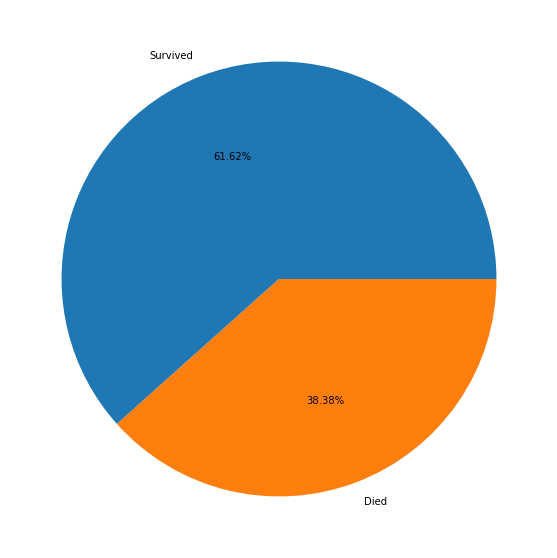

In [12]:
outcome = df['Survived'][0:891].replace([0.0, 1.0], ['Survived', 'Died'])

values = outcome.value_counts() # Count the unique values of 'Survided' column
labels = outcome.unique() # Extract unique values of 'Survided' column (0 and 1)

# Pie Chart: 0 for Died and 1 for Survived
fig, ax = plt.subplots(figsize = (10,10))
ax.pie(values, labels=labels, autopct='%1.2f%%')
plt.show()


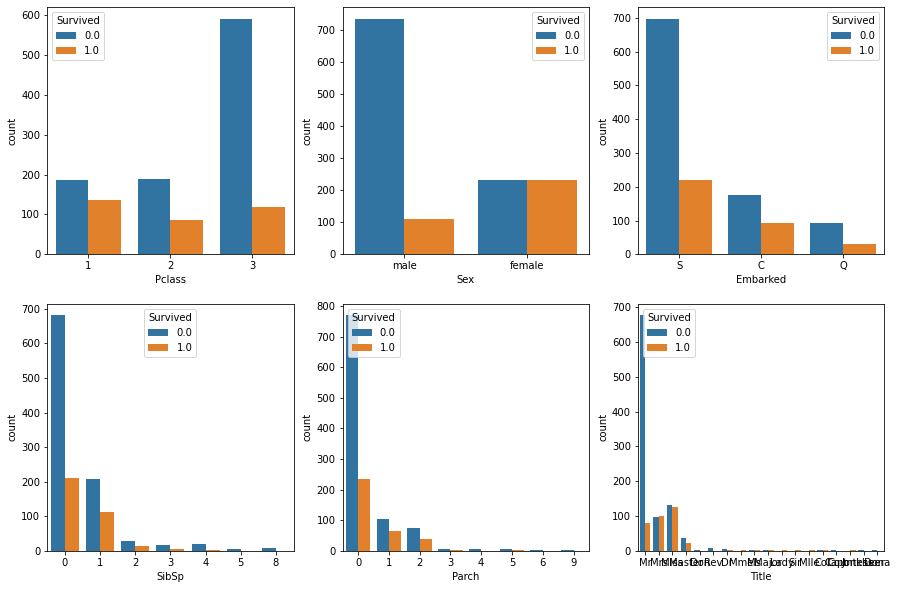

In [13]:
fig, axs = plt.subplots(2, 3, figsize = (15,10))

sns.countplot(ax=axs[0, 0], x=df['Pclass'], hue=df['Survived'])
sns.countplot(ax=axs[0, 1], x=df['Sex'], hue=df['Survived'])
sns.countplot(ax=axs[0, 2], x=df['Embarked'], hue=df['Survived'])
sns.countplot(ax=axs[1, 0], x=df['SibSp'], hue=df['Survived'])
sns.countplot(ax=axs[1, 1], x=df['Parch'], hue=df['Survived'])
sns.countplot(ax=axs[1, 2], x=df['Title'], hue=df['Survived'])

plt.show()

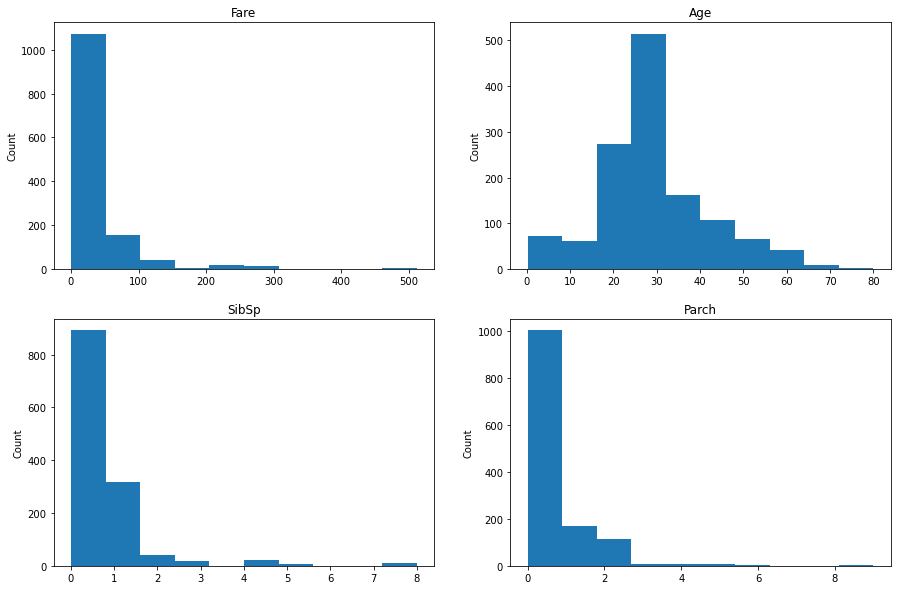

In [14]:
fig, axs = plt.subplots(2,2, figsize=(15,10))

axs[0, 0].hist(df['Fare'], 10)
axs[0, 0].set_title('Fare')
axs[0, 0].set_ylabel('Count')

axs[0, 1].hist(df['Age'], 10)
axs[0, 1].set_title('Age')
axs[0, 1].set_ylabel('Count')

axs[1, 0].hist(df['SibSp'], 10)
axs[1, 0].set_title('SibSp')
axs[1, 0].set_ylabel('Count')

axs[1, 1].hist(df['Parch'], 10)
axs[1, 1].set_title('Parch')
axs[1, 1].set_ylabel('Count')

plt.show()

In [15]:
df.corr().style.background_gradient(cmap="Blues")

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.244686,-0.059791,-0.014375,0.054908,0.173639
Pclass,-0.244686,1.000000,-0.367544,0.060832,0.018322,-0.558491
Age,-0.059791,-0.367544,1.000000,-0.190700,-0.130405,0.172220
SibSp,-0.014375,0.060832,-0.190700,1.000000,0.373587,0.160232
Parch,0.054908,0.018322,-0.130405,0.373587,1.000000,0.221529
Fare,0.173639,-0.558491,0.172220,0.160232,0.221529,1.000000


### One Hot Encoding

In [16]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Col,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,0.0,3,22.0,1,0,7.2500,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,1.0,1,38.0,1,0,71.2833,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1.0,3,26.0,0,0,7.9250,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,1.0,1,35.0,1,0,53.1000,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0.0,3,35.0,0,0,8.0500,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [17]:
df.shape

(1309, 26)

In [18]:
df.corr().style.background_gradient(cmap="Blues")

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Col,Title_Countess,Title_Don,Title_Dona,Title_Dr,Title_Jonkheer,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
Survived,1.000000,-0.244686,-0.059791,-0.014375,0.054908,0.173639,-0.404020,-0.012730,-0.077095,-0.001420,0.046494,-0.016444,-0.016444,0.020300,-0.016444,0.046494,0.021257,0.058265,0.257459,0.065778,0.046494,-0.411211,0.231152,0.021257,-0.046634,0.046494
Pclass,-0.244686,1.000000,-0.367544,0.060832,0.018322,-0.558491,0.124617,0.230491,0.091320,-0.085598,-0.042750,-0.042750,-0.042750,-0.097832,-0.042750,-0.042750,-0.060480,0.095257,0.030478,-0.060480,-0.042750,0.121492,-0.178808,0.009581,-0.027610,-0.042750
Age,-0.059791,-0.367544,1.000000,-0.190700,-0.130405,0.172220,0.057044,-0.014505,-0.057926,0.103842,0.006775,0.021804,0.019657,0.073024,0.017510,0.038980,0.056665,-0.363699,-0.253064,-0.017753,-0.012548,0.164951,0.200989,-0.003022,0.069447,0.041127
SibSp,-0.014375,0.060832,-0.190700,1.000000,0.373587,0.160232,-0.109609,-0.048678,0.073709,-0.013232,-0.013247,-0.013247,-0.013247,0.009500,-0.013247,0.013308,-0.018741,0.329171,0.079622,-0.018741,-0.013247,-0.243104,0.065098,-0.018741,-0.018741,0.013308
Parch,0.054908,0.018322,-0.130405,0.373587,1.000000,0.221529,-0.213125,-0.100943,0.071881,-0.024637,-0.012304,-0.012304,-0.012304,-0.023566,-0.012304,-0.012304,-0.017408,0.253482,0.068368,-0.017408,-0.012304,-0.304780,0.217673,-0.017408,-0.012238,-0.012304
Fare,0.173639,-0.558491,0.172220,0.160232,0.221529,1.000000,-0.185496,-0.130049,-0.169905,0.049481,0.028445,-0.002980,0.040420,0.030263,-0.017800,0.003371,-0.003608,0.011600,0.090391,0.019747,0.019249,-0.192206,0.140515,-0.017335,-0.022266,0.012635
Sex_male,-0.404020,0.124617,0.057044,-0.109609,-0.213125,-0.185496,1.000000,-0.088651,0.115193,0.041163,-0.037189,0.020558,-0.037189,0.037831,0.020558,-0.037189,0.029084,0.164375,-0.669607,-0.052614,-0.037189,0.870678,-0.566111,-0.052614,0.058302,0.020558
Embarked_Q,-0.012730,0.230491,-0.014505,-0.048678,-0.100943,-0.130049,-0.088651,1.000000,-0.491656,-0.017829,-0.008904,-0.008904,-0.008904,0.008341,-0.008904,-0.008904,-0.012598,-0.009091,0.200610,-0.012598,-0.008904,-0.080224,-0.106257,0.054436,0.008341,-0.008904
Embarked_S,-0.077095,0.091320,-0.057926,0.073709,0.071881,-0.169905,0.115193,-0.491656,1.000000,-0.054326,0.018111,-0.042213,-0.042213,-0.012792,0.018111,-0.042213,0.025623,0.018297,-0.108367,-0.059721,-0.042213,0.108924,-0.017969,-0.017049,0.029978,-0.042213
Title_Col,-0.001420,-0.085598,0.103842,-0.013232,-0.024637,0.049481,0.041163,-0.017829,-0.054326,1.000000,-0.001531,-0.001531,-0.001531,-0.004341,-0.001531,-0.001531,-0.002166,-0.012240,-0.027563,-0.002166,-0.001531,-0.064834,-0.023303,-0.002166,-0.004341,-0.001531


### Model

In [19]:
# Split features and labels.
X = df[0:891].drop('Survived', axis=1)
Y = df['Survived'][0:891]

In [20]:
print(X.shape)
print(Y.shape)

(891, 25)
(891,)


In [21]:
# Split Train ans Test for modeling.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=4)

In [22]:
# Create a list of models we intend to 
models = [('Logistic Regression', LogisticRegression()),
         ('KNN', KNeighborsClassifier()),
         ('Decision Tree', DecisionTreeClassifier()),
         ('Random Forest', RandomForestClassifier()),
         ('Ada Boost', AdaBoostClassifier()),
         ('XGB', XGBClassifier()),
         ('Support Vector', SVC()),
         ('Gaussian Naive Bayes', GaussianNB())]

In [23]:
for name, model in models:
    model.fit(x_train, y_train)
    y_hat = model.predict(x_train)
    Acc_train = accuracy_score(y_train, y_hat)
    y_hat2 = model.predict(x_test)
    Acc_test = accuracy_score(y_test, y_hat2)
    print(f'{name} Train Accuracy: {Acc_train} \n{name} Test Accuracy: {Acc_test} \n')

Logistic Regression Train Accuracy: 0.8230337078651685 
Logistic Regression Test Accuracy: 0.8659217877094972 



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


KNN Train Accuracy: 0.8033707865168539 
KNN Test Accuracy: 0.7541899441340782 

Decision Tree Train Accuracy: 0.9845505617977528 
Decision Tree Test Accuracy: 0.8491620111731844 

Random Forest Train Accuracy: 0.9845505617977528 
Random Forest Test Accuracy: 0.8156424581005587 

Ada Boost Train Accuracy: 0.8412921348314607 
Ada Boost Test Accuracy: 0.8100558659217877 

XGB Train Accuracy: 0.9676966292134831 
XGB Test Accuracy: 0.8435754189944135 

Support Vector Train Accuracy: 0.6839887640449438 
Support Vector Test Accuracy: 0.6983240223463687 

Gaussian Naive Bayes Train Accuracy: 0.6657303370786517 
Gaussian Naive Bayes Test Accuracy: 0.7094972067039106 



### Tuning the Hyper-Parameters

In [24]:
params = {'n_estimators':[50,100,150,200,250,300],
         'max_depth': [50, 100, 150, 200, None],
         'max_features': ['sqrt', 'log2', None]}
clf = GridSearchCV(estimator = RandomForestClassifier(),
                   param_grid = params,
                   scoring= 'accuracy',
                   n_jobs=-1, 
                   cv=5, 
                   verbose=1)
clf.fit(x_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [50, 100, 150, 200, None],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             scoring='accuracy', verbose=1)

In [25]:
print(clf.best_params_)

{'max_depth': 150, 'max_features': None, 'n_estimators': 150}


In [26]:
clf = RandomForestClassifier(n_estimators=100,
                             max_depth=50, 
                             max_features=None)

In [27]:
clf.fit(x_train, y_train)

RandomForestClassifier(max_depth=50, max_features=None)

### Submit to Competiotion

In [28]:
submit = df[891:]
submit.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Col,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,0.0,3,34.5,0,0,7.8292,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.0,3,47.0,1,0,7.0000,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0.0,2,62.0,0,0,9.6875,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.0,3,27.0,0,0,8.6625,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0.0,3,22.0,1,1,12.2875,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [29]:
submit.drop('Survived', axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
submit['Survived'] = clf.predict(submit)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
submit.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Col,Title_Countess,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Survived
0,3,34.5,0,0,7.8292,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0.0
1,3,47.0,1,0,7.0000,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0.0
2,2,62.0,0,0,9.6875,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1.0
3,3,27.0,0,0,8.6625,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0.0
4,3,22.0,1,1,12.2875,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1.0


In [32]:
submit['PassengerId'] = test['PassengerId']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
submit.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Col,Title_Countess,...,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Survived,PassengerId
0,3,34.5,0,0,7.8292,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0.0,892
1,3,47.0,1,0,7.0000,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0.0,893
2,2,62.0,0,0,9.6875,1,1,0,0,0,...,0,0,0,1,0,0,0,0,1.0,894
3,3,27.0,0,0,8.6625,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0.0,895
4,3,22.0,1,1,12.2875,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1.0,896


In [34]:
# Keep only 'PassengerId' and 'Survived' columns for submission.
submit = submit[['PassengerId','Survived']]

In [35]:
submit.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,1.0
3,895,0.0
4,896,1.0


In [36]:
# Convert 'Survived' column values data type from float to int.
submit['Survived'] = submit['Survived'].astype('int64')

In [37]:
# Save DataFrame to '.csv' and remove index for submission.
submit.to_csv('submission.csv', index=False)